# Homework 1 - Problem 1 - simulate 3 spheres

# Imports

Notes on using cupy
https://docs.cupy.dev/en/stable/install.html

Cupy is a drop-in replacement for numpy, but it should be faster because it uses the GPU in my computer to run calculations.
So, we replace `import numpy as np` with `import cupy as np`.... if possible.

For this to work, you need an NVIDIA GPU and CUDA toolkit installed. 
I have a 1650Ti.
I can check the highest version of CUDA that can be installed by running `nvidia-smi`: the highest possible cuda toolkit version is showed in top right.
* This does NOT mean you already have the toolkit.
* So I install the toolkit (12.5) here:
* https://developer.nvidia.com/cuda-12-5-0-download-archive?target_os=Windows&target_arch=x86_64&target_version=11&target_type=exe_local


Thereafter, i can pip-install cupy (for the cuda 12 version) in my python `venv` as follows:
* `pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124`
    * this is neeeded to install pytorch to access the cuda toolkit
    * check for the specific version of pytorch you need here: https://pytorch.org/get-started/locally/ 
*  `pip install cupy-cuda12x` 


Since i'm running python in a venv, i need to make the CUDA Toolkit accessible.
* in powershell of the venv enter: `export CUDA_PATH="C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA"  # Replace with your actual path` 
* Go to my `.venv` -> `pyvenv.cfg` 
* include-system-site-packages = true

In [1]:
# imports for python things.
import os

# Imports for numpy OR cupy
import numpy as np
cupy_active = False

# import cupy as np  # this is a drop-in replacement for numpy, that uses the GPU instead of CPU for speed.
# cupy_active = True

# Imports for math
import matplotlib.pyplot as plt
from IPython.display import clear_output # Only for iPython

######################################## Import the functions written by Prof for class:
# Could do an "helper_imports.py" file package in the future for nice consolidation
from computekappa import computekappa
from crossMat import crossMat
from gradEb_hessEb import gradEb_hessEb
from gradEb import gradEb
from gradEs_hessEs import gradEs_hessEs
from gradEs import gradEs
from gradEt_hessEt import gradEt_hessEt_panetta
from hessEb import hessEb
from hessEs import hessEs
from rotateAxisAngle import rotateAxisAngle

# Additional helper functions for this homework
from getFb import getFb 
from getFs import getFs

# Parameters for Homework 1 Problem 1

In [2]:
# Time Stamps for snapshot:
timestamps_for_report = [0, 0.01, 0.05, 0.10, 1.0, 10.0]  # Make sure these timestamps are within resolution of dt_setting!!!

# Indicate whether images should be saved
# saveImage = False
saveImage = True

# Total simulation time (it exits after t=totalTime)
totalTime = 10

quietRun = False

# Constants for Simulation Environment

In [20]:
# Inputs (SI units)
# number of vertices
nv = 3 # Odd vs even number should show different behavior
ndof = 2*nv

# Rod Length
RodLength = 0.10  # [m]

# Discrete length
deltaL = RodLength / (nv - 1)  # [m]

# Radius of spheres - General Formulation
midNode = int((nv + 1) / 2)

# if cupy_active:
#     # Radius of spheres - Homework Assignment 1
#     R = np.array([0.005, 0.025, 0.005]) # --> this is calculated from general for nv = 3
# else:

R = np.zeros(nv)  # Vector of size N - Radius of N nodes
R[:] = 0.005 # deltaL / 10: Course note uses deltaL/10
R[midNode -1 ] = 0.025
# R[midNode -1 ] = 0.005  # For deliverable 3.
# R units are [m]


# Densities
rho_metal = 7000  # [kg / m^3]
rho_gl = 1000  # [kg / m^3]
rho = rho_metal - rho_gl

# Cross-sectional radius of rod
r0 = 1e-3  # [m]

# Young's modulus
Y = 1e9  # [Pa]

# Viscosity
visc = 1000.0  # [Pa-s]

# Maximum number of iterations in Newton Solver
maximum_iter = 100

# Utility quantities
ne = nv - 1
EI = Y * np.pi * r0**4 / 4  # Bending Stiffness
EA = Y * np.pi * r0**2      # Stretching stiffness

# Tolerance on force function
tol = EI / RodLength**2 * 1e-3  # small enough force that can be neglected

# Geometry of the rod
nodes = np.zeros((nv, 2))
for c in range(nv):
    nodes[c, 0] = c * RodLength / ne


# Compute Mass
m = np.zeros(ndof)
for k in range(nv):
    m[2*k] = 4 / 3 * np.pi * R[k]**3 * rho_metal # Mass for x_k
    m[2*k+1] = m[2*k] # Mass for y_k

mMat = np.diag(m)  # Convert into a diagonal matrix

# Gravity
W = np.zeros(ndof)
g = np.array([0, -9.8])  # m/s^2 - gravity
for k in range(nv):
  # Just weight by itself:
  # W[2*k]   = m[2*k] * g[0] # Weight for x_k
  # W[2*k+1] = m[2*k] * g[1] # Weight for y_k

  # Factoring Buoyancy:
  W[2*k]   = 0 # Weight for x_k
  W[2*k+1] = 4 / 3 * np.pi * R[k]**3 * rho * g[1] # Weight for y_k

# Viscous damping matrix, C
C = np.zeros((ndof, ndof))
for k in range(nv):
  C[2*k,2*k]   = 6 * np.pi * visc * R[k]
  C[2*k+1, 2*k+1]   = 6 * np.pi * visc * R[k]



## Figure out fixed and free DOFs

In [4]:
all_DOFs = np.arange(ndof)
# fixed_index = np.array([0, 1])
fixed_index = np.array([])  # All are free.

# Get the difference of two sets using np.setdiff1d
free_index = np.setdiff1d(all_DOFs, fixed_index)

# Objective Functions

We define our equations of motion within the objective function, in order to compute f

## Objective Function - Implicit

In [5]:
def objfun_implicit(q_guess, q_old, u_old, dt, tol, maximum_iter,
           m, mMat,  # inertia
           EI, EA,   # elastic stiffness
           W, C,     # external force
           deltaL,
           free_index): # free_index indicates the DOFs that evolve under equations of motion
    """
    Returns the new position vector "q" of all points for all given inputs.
    Also returns a flag to indicate success or failure of the computation.
    This new position vector "q" is calculated with the implicit method via NewtonRaphson method convergence.

    Parameters:
    q_guess : float
        The guessed locality of the final solution, to ensure continuity and convergence, typically just the q_old point.
    q_old: float
        The previous q point from the last t timestamp.
    u_old: float
        The previous velocity u vector from the last t timestamp.
    dt: float
        The time between timestamps for simulation.
    tol: float
        The tolerance with which we deem the Newton Raphson solution is sufficiently converged
    maximum_iter: float
        Maximum number of iterations to try convergence, to make sure computer doesn't hang forever. 
    m, mMat: 
        mass matrices
    EI, EA:
        elastic stiffnesses: EA - stretching, EI - bending
    W, C:
        external forces - weight(W) and XXXX(C)
    deltaL:
        something
    free_index:
        free_index indicates the DOFs that evolve under equations of motion

    Returns:
    q_new : np.ndarray
       The new vector of positions at k+1
    flag: int
        1 if no error, -1 if fail to converge
    """

    q_new = q_guess.copy()

    # Newton-Raphson scheme
    iter_count = 0  # number of iterations
    error = tol * 10  # norm of function value (initialized to a value higher than tolerance)
    flag = 1  # Start with a 'good' simulation (flag=1 means no error)

    while error > tol:
        # Get elastic forces
        Fb, Jb = getFb(q_new, EI, deltaL)  # bending
        Fs, Js = getFs(q_new, EA, deltaL)  # stretching

        # Viscous force
        Fv = -C @ (q_new - q_old) / dt
        Jv = -C / dt

        ##################################################################
        # Equation of motion
        # Implicit
        f = m * (q_new - q_old) / dt**2 - m * u_old / dt - (Fb + Fs + W + Fv)
        # Explicit
        # f = 

        # Manipulate the Jacobians
        J = mMat / dt**2 - (Jb + Js + Jv)

        # We have to separate the "free" parts of f and J
        f_free = f[free_index]
        J_free = J[np.ix_(free_index, free_index)]

        # Newton's update
        # q_new = q_new - np.linalg.solve(J, f)
        # We have to only update the free DOFs
        dq_free = np.linalg.solve(J_free, f_free)
        q_new[free_index] = q_new[free_index] - dq_free

        # Get the norm
        # error = np.linalg.norm(f)
        # We have to calculate the errors based on free DOFs
        error = np.linalg.norm(f_free)

        # Update iteration number
        iter_count += 1
        if not quietRun:
            print(f'Iter={iter_count-1}, error={error:.6e}')

        if iter_count > maximum_iter:
            flag = -1  # return with an error signal
            return q_new, flag

    return q_new, flag

## Objective Function - Explicit

In [6]:
def objfun_explicit(q_guess, q_old, u_old, dt, tol, maximum_iter,
           m, mMat,  # inertia
           EI, EA,   # elastic stiffness
           W, C,     # external force
           deltaL,
           free_index): # free_index indicates the DOFs that evolve under equations of motion
    """
    Returns the new position vector "q" of all points for all given inputs.
    Also returns a flag to indicate success or failure of the computation.
    This new position vector "q" is calculated with the explicit method.
    There are redundant arguments in this function for ease of drop-in-and-replace of this function when called from Main().

    Parameters:
    q_guess : float
        The guessed locality of the final solution, to ensure continuity and convergence, typically just the q_old point.
    q_old: float
        The previous q point from the last t timestamp.
    u_old: float
        The previous velocity u vector from the last t timestamp.
    dt: float
        The time between timestamps for simulation.
    tol: float
        The tolerance with which we deem the Newton Raphson solution is sufficiently converged
    maximum_iter: float
        Maximum number of iterations to try convergence, to make sure computer doesn't hang forever. 
    m, mMat: 
        mass matrices
    EI, EA:
        elastic stiffnesses
    W, C:
        external forces
    deltaL:
        something
    free_index:
        free_index indicates the DOFs that evolve under equations of motion

    Returns:
    q_new : np.ndarray
       The new vector of positions at k+1
    flag: int
        1 if no error, -1 if fail to converge
    """
    q_new = q_guess.copy()

    # Newton-Raphson scheme
    iter_count = 0  # number of iterations
    error = tol * 10  # norm of function value (initialized to a value higher than tolerance)
    flag = 1  # Start with a 'good' simulation (flag=1 means no error)

    # while error > tol:
    # Get elastic forces
    Fb, Jb = getFb(q_old, EI, deltaL)  # bending
    Fs, Js = getFs(q_old, EA, deltaL)  # stretching

    # Viscous force
    Fv = -C @ u_old
    # Jv = -C / dt

    ##################################################################
    # Equation of motion
    # Implicit
    # f = m * (q_new - q_old) / dt**2 - m * u_old / dt - (Fb + Fs + W + Fv)
    # Explicit
    q_new = q_old + (dt**2 / m) * (Fb+Fs+W+Fv + m*(u_old/dt))
    print(q_new)

    return q_new, flag

# Main - Run Simulation

In [7]:
for x in range(1, 3):
    print(x)

dt = 1e-5
print(round(totalTime / dt))

1
2
1000000


## Define a main function that can be called later, with either implicit or explicit mode.

In [8]:
def main(additional_cases_for_homework_string = ''):
   # Time step
  dt = dt_setting  # from above, for this homework assignment

  # Initial conditions
  q0 = np.zeros(ndof)
  for c in range(nv):
      q0[2 * c] = nodes[c, 0]
      q0[2 * c + 1] = nodes[c, 1]

  q = q0.copy()
  u = (q - q0) / dt


  # Number of time steps
  Nsteps = round(totalTime / dt) + 1

  ctime = 0

  all_pos = np.zeros(Nsteps)
  all_v = np.zeros(Nsteps)
  midAngle = np.zeros(Nsteps)


  for timeStep in range(1, Nsteps):  # Python uses 0-based indexing, hence range starts at 1
      if not quietRun:
        print(f't={ctime:.6f}')

      if mode == 'implicit':
        q, error = objfun_implicit(q0, q0, u, dt, tol, maximum_iter, m, mMat, EI, EA, W, C, deltaL,
                          free_index) # This line is different from our previous exercise
      else:
        q, error = objfun_explicit(q0, q0, u, dt, tol, maximum_iter, m, mMat, EI, EA, W, C, deltaL,
                          free_index) # This line is different from our previous exercise

      if error < 0:
          print('Could not converge. Sorry')
          break  # Exit the loop if convergence fails

      u = (q - q0) / dt  # velocity
      ctime += dt  # current time

      # Update q0
      q0 = q


      if (not saveImage and timeStep % plotStep == 0
          ) or (saveImage and (timeStep*dt) in timestamps_for_report):
        
        x1 = q[::2]  # Selects every second element starting from index 0
        x2 = q[1::2]  # Selects every second element starting from index 1
        h1 = plt.figure(1)
        plt.clf()  # Clear the current figure
        clear_output(wait=True)  # Clear the previous plot/output: Only for iPython
        plt.plot(x1, x2, 'ko-')  # 'ko-' indicates black color with circle markers and solid lines
        plt.title(mode + f' t={ctime:.6f}')  # Format the title with the current time
        plt.axis('equal')  # Set equal scaling
        plt.xlabel('x [m]')
        plt.ylabel('y [m]')
        # plt.show()  # Display the figure

        if not saveImage:
          plt.show()  # Display the figure
        else:  # because plt.show() messes up the savefig thing.
          filepath_fig_save = r'C:\Users\limhe\OneDrive\Documents\0_Classes UCLA\0_MAE 263F_Mechanics of Flexible Structures and Soft Robots\HW1'
          save_filename = 'hw1_p1_structureShape_t=' + str(timeStep*dt).replace('.', '_') + '.png'
          if mode == 'implicit':
            save_filename = 'hw1_p1_structureShape_implicit' + additional_cases_for_homework_string + '_t=' + str(timeStep*dt).replace('.', '_') + '.png'
          else:
            save_filename = 'hw1_p1_structureShape_explicit' + additional_cases_for_homework_string + '_t=' + str(timeStep*dt).replace('.', '_') + '.png'
          print(os.path.join(filepath_fig_save, save_filename))
          plt.savefig(os.path.join(filepath_fig_save, save_filename), 
                      # transparent=True, 
                      dpi=300,
                      )


      all_pos[timeStep] = q[2*midNode-1]  # Python uses 0-based indexing
      all_v[timeStep] = u[2*midNode-1]

      # Angle at the center
      vec1 = np.array([q[2*midNode-2], q[2*midNode-1], 0]) - np.array([q[2*midNode-4], q[2*midNode-3], 0])
      vec2 = np.array([q[2*midNode], q[2*midNode+1], 0]) - np.array([q[2*midNode-2], q[2*midNode-1], 0])
      midAngle[timeStep] = np.degrees(np.arctan2(np.linalg.norm(np.cross(vec1, vec2)), np.dot(vec1, vec2)))


  # Plot
  plt.figure(2)
  t = np.linspace(0, totalTime, Nsteps)
  plt.plot(t, all_pos)
  plt.xlabel('Time, t [s]')
  plt.ylabel('Displacement, $\\delta$ [m]')
  # plt.savefig('fallingBeam.png')
  if mode == 'implicit':
      save_filename = 'fallingBeam_implicit' + additional_cases_for_homework_string + '.png'
  else:
      save_filename = 'fallingBeam_explicit' + additional_cases_for_homework_string + '.png'
  filepath_fig_save = r'C:\Users\limhe\OneDrive\Documents\0_Classes UCLA\0_MAE 263F_Mechanics of Flexible Structures and Soft Robots\HW1'
  print(os.path.join(filepath_fig_save, save_filename))
  plt.savefig(os.path.join(filepath_fig_save, save_filename), 
              # transparent=True, 
              dpi=300,
              )

  plt.figure(3)
  plt.plot(t, all_v)
  plt.xlabel('Time, t [s]')
  plt.ylabel('Velocity, v [m/s]')
  # plt.savefig('fallingBeam_velocity.png')
  if mode == 'implicit':
      save_filename = 'fallingBeam_velocity_implicit' + additional_cases_for_homework_string + '.png'
  else:
      save_filename = 'fallingBeam_velocity_explicit' + additional_cases_for_homework_string + '.png'
  filepath_fig_save = r'C:\Users\limhe\OneDrive\Documents\0_Classes UCLA\0_MAE 263F_Mechanics of Flexible Structures and Soft Robots\HW1'
  print(os.path.join(filepath_fig_save, save_filename))
  plt.savefig(os.path.join(filepath_fig_save, save_filename), 
              # transparent=True, 
              dpi=300,
              )

  plt.figure(4)
  plt.plot(t, midAngle, 'r')
  plt.xlabel('Time, t [s]')
  plt.ylabel('Angle, $\\alpha$ [deg]')
  # plt.savefig('fallingBeam_angle.png')
  if mode == 'implicit':
      save_filename = 'fallingBeam_angle_implicit' + additional_cases_for_homework_string + '.png'
  else:
      save_filename = 'fallingBeam_angle_explicit' + additional_cases_for_homework_string + '.png'
  filepath_fig_save = r'C:\Users\limhe\OneDrive\Documents\0_Classes UCLA\0_MAE 263F_Mechanics of Flexible Structures and Soft Robots\HW1'
  print(os.path.join(filepath_fig_save, save_filename))
  plt.savefig(os.path.join(filepath_fig_save, save_filename), 
              # transparent=True, 
              dpi=300,
              )

  plt.show()

  return t, all_pos, all_v, midAngle

## Implicit Method

C:\Users\limhe\OneDrive\Documents\0_Classes UCLA\0_MAE 263F_Mechanics of Flexible Structures and Soft Robots\HW1\hw1_p1_structureShape_implicit_dt=1e-3__t=10_0.png
C:\Users\limhe\OneDrive\Documents\0_Classes UCLA\0_MAE 263F_Mechanics of Flexible Structures and Soft Robots\HW1\fallingBeam_implicit_dt=1e-3_.png
C:\Users\limhe\OneDrive\Documents\0_Classes UCLA\0_MAE 263F_Mechanics of Flexible Structures and Soft Robots\HW1\fallingBeam_velocity_implicit_dt=1e-3_.png
C:\Users\limhe\OneDrive\Documents\0_Classes UCLA\0_MAE 263F_Mechanics of Flexible Structures and Soft Robots\HW1\fallingBeam_angle_implicit_dt=1e-3_.png


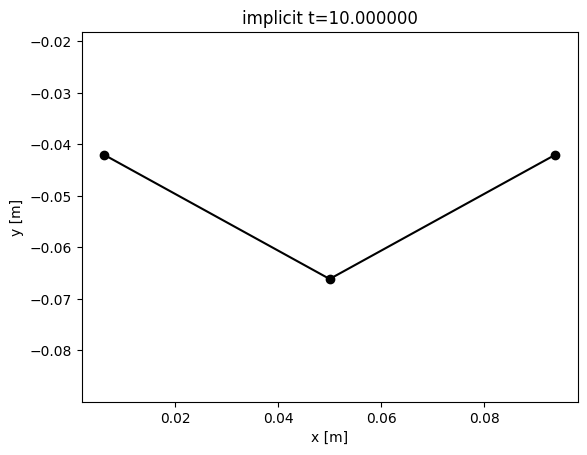

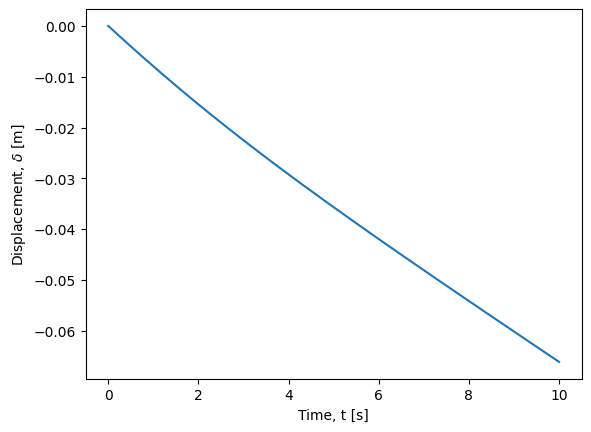

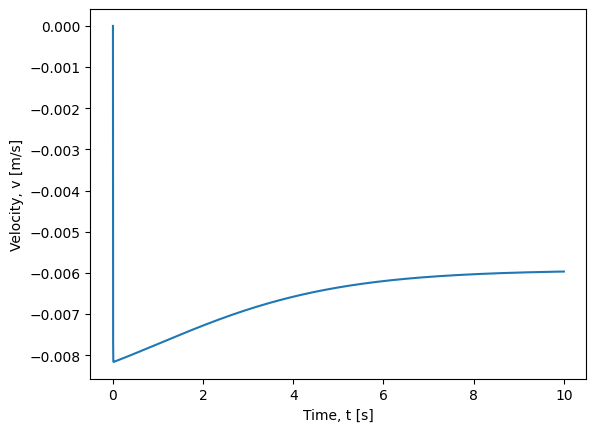

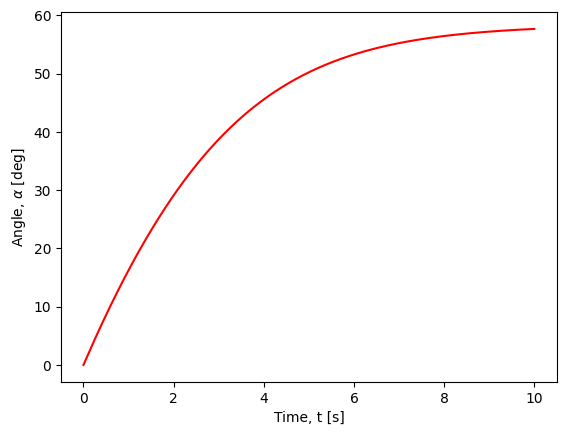

Implicit 1e-3 Terminal Velocity is: -0.005965730463602936


In [17]:
# # TEST RUN
# mode = 'implicit'
# quietRun = False
# saveImage = False
# dt_setting = 1e-2
# plotStep = 50
# t, all_pos, all_v, midAngle = main()


# ACTUAL RUN
saveImage = True
# Implicit Parameters
mode = 'implicit'
quietRun = True
dt_setting = 1e-2
plotStep = 50
t, all_pos, all_v, midAngle = main()

# terminal velocity
terminal_velocity_implicit_1e_2_step50 = all_v[-1]
print('Implicit 1e-2 Terminal Velocity is: ' + str(all_v[-1]))

# Other Cases
mode = 'implicit'
dt_setting = 1
plotStep = 1
t, all_pos, all_v, midAngle = main(additional_cases_for_homework_string = '_dt=1_')
terminal_velocity_implicit_1e_0_step2 = all_v[-1]

# Other Cases
mode = 'implicit'
dt_setting = 1e-3
plotStep = 500
t, all_pos, all_v, midAngle = main(additional_cases_for_homework_string = '_dt=1e-3_')
terminal_velocity_implicit_1e_0_step1 = all_v[-1]
print('Implicit 1e-3 Terminal Velocity is: ' + str(all_v[-1]))
# terminal_velocity_5e_6 = all_v[-1]

In [18]:
terminal_velocity_implicit_1e_0_step2

-0.006008498519768937

## Explicit Method

C:\Users\limhe\OneDrive\Documents\0_Classes UCLA\0_MAE 263F_Mechanics of Flexible Structures and Soft Robots\HW1\hw1_p1_structureShape_explicit_dt=5e-6__t=10_0.png
C:\Users\limhe\OneDrive\Documents\0_Classes UCLA\0_MAE 263F_Mechanics of Flexible Structures and Soft Robots\HW1\fallingBeam_explicit_dt=5e-6_.png
C:\Users\limhe\OneDrive\Documents\0_Classes UCLA\0_MAE 263F_Mechanics of Flexible Structures and Soft Robots\HW1\fallingBeam_velocity_explicit_dt=5e-6_.png
C:\Users\limhe\OneDrive\Documents\0_Classes UCLA\0_MAE 263F_Mechanics of Flexible Structures and Soft Robots\HW1\fallingBeam_angle_explicit_dt=5e-6_.png


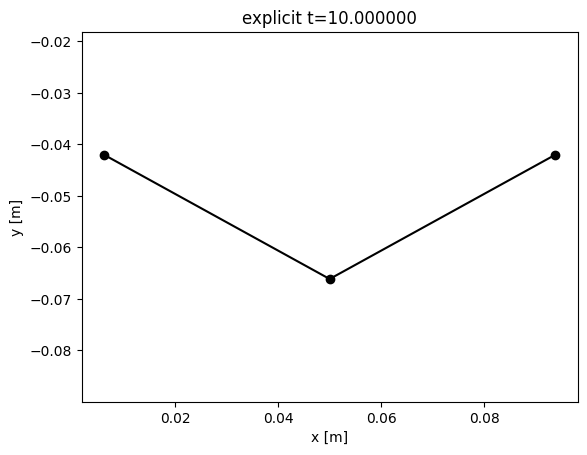

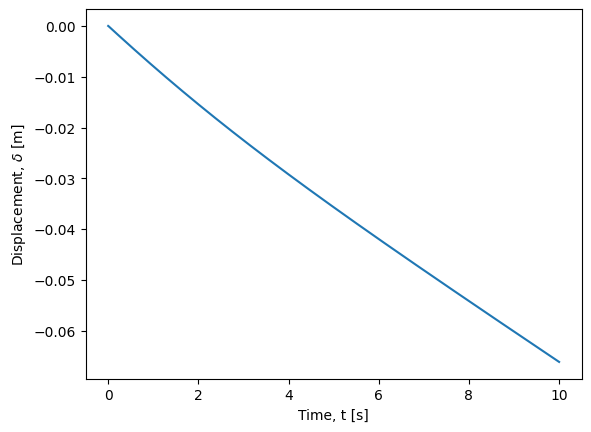

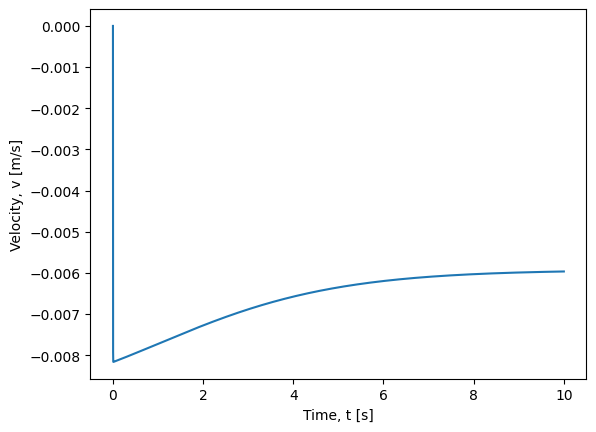

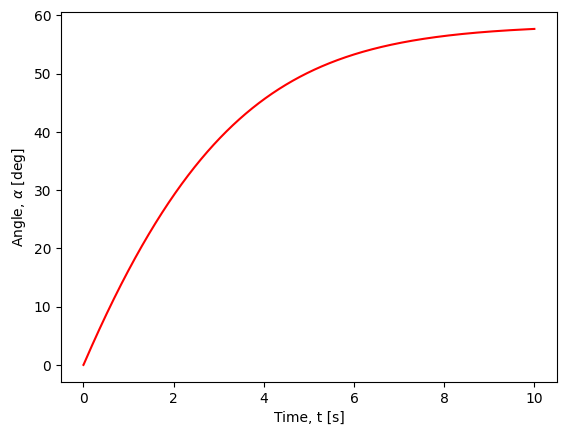

Explicit 5e-5 Terminal Velocity is: -0.005965693015974605


In [10]:
# # TEST RUN
# # Explicit Parameters
# mode = 'explicit'
# quietRun = False
# saveImage = False
# totalTime = 1
# dt_setting = 1e-5
# plotStep = 2500
# t, all_pos, all_v, midAngle = main()
# saveImage = True
# totalTime = 10

# ACTUAL RUN

# Explicit Parameters
mode = 'explicit'
quietRun = True
dt_setting = 1e-5
plotStep = 50000
t, all_pos, all_v, midAngle = main()
# terminal velocity
terminal_velocity_explicit_1e_5_step50000 = all_v[-1]
# terminal_velocity_implicit_1e_0_step1 = all_v[-1]
print('Explicit 1e-5 Terminal Velocity is: ' + str(all_v[-1]))

# # Other Cases
# mode = 'explicit'
# dt_setting = 1e-1
# plotStep = 5
# t, all_pos, all_v, midAngle = main(additional_cases_for_homework_string = '_dt=1e-1_')
# terminal_velocity_explicit_1e_1_step5 = all_v[-1]

# Other Cases
mode = 'explicit'
dt_setting = 0.8e-5
plotStep = 100000
t, all_pos, all_v, midAngle = main(additional_cases_for_homework_string = '_dt=5e-6_')
terminal_velocity_explicit_5e_5_step100000 = all_v[-1]
print('Explicit 5e-5 Terminal Velocity is: ' + str(all_v[-1]))

In [12]:
terminal_velocity_explicit_1e_5_step50000


-0.005965693018750161